In [36]:
import pandas as pd
import numpy as np
import torch
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display

from typing import List, Tuple


class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

In [37]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


from rdkit.Chem import rdMolDescriptors

class GraphFeaturizer(Featurizer):
    def __call__(self, df, getRepresentation):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                begin = bond.GetBeginAtomIdx()
                end = bond.GetEndAtomIdx()
                edges.append((begin, end))  # TODO: Add edges in both directions
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                # print(atom.GetAtomicNum(), atom.GetNumImplicitHs(), atom.GetTotalNumHs(), atom.GetSymbol(), atom.GetNumExplicitHs(), atom.GetTotalValence())
                results = getRepresentation(atom)
                # print(results)
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return [Data(
            x=torch.FloatTensor(x), 
            edge_index=torch.LongTensor(edge_index), 
            y=torch.FloatTensor([y])
        ) for ((x, edge_index), y) in zip(graphs, labels)]

In [38]:
def defaultRepresentation(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(11)) + one_of_k_encoding(
                    atom.GetDegree(), range(11)
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(), range(11)
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(11)
                ) + [atom.GetNumImplicitHs(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.IsInRing()] # TODO: Add atom features as a list, you can use one_of_k_encodings defined above

def representation1(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(12)) + one_of_k_encoding_unk(
                    atom.GetDegree(), range(6)) + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(5)
                ) + [atom.GetFormalCharge(), atom.IsInRing(), atom.GetIsAromatic()]

def representation10(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(12)) + one_of_k_encoding_unk(
                    atom.GetDegree(), range(6)) + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(5)
                ) + [atom.IsInRing(), atom.GetIsAromatic()]

def representationAll(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(12)) + one_of_k_encoding_unk(
                    atom.GetDegree(), range(6)) + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(5)) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(), range(6))  + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetFormalCharge(), atom.IsInRing(), atom.GetIsAromatic()
                     ] + [atom.GetNumRadicalElectrons()]

def printProperties(atom):
    print("=========")
    print("GetDegree", atom.GetDegree())
    print("GetImplicitValence", atom.GetImplicitValence())
    print("GetAtomicNum", atom.GetAtomicNum())
    print("GetTotalNumHs", atom.GetTotalNumHs())
    print("GetNumImplicitHs", atom.GetNumImplicitHs())
    print("GetNeighbors", atom.GetNeighbors())
    print("GetNumExplicitHs", atom.GetNumExplicitHs())
    print("GetTotalDegree", atom.GetTotalDegree())
    print("GetTotalNumHs", atom.GetTotalNumHs())
    print("GetTotalValence", atom.GetTotalValence())

In [39]:
class ECFPFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)
            labels.append(y)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels

data = ADME('Solubility_AqSolDB')
split = data.get_split()
rmse = Evaluator(name = 'RMSE')

featurizer = ECFPFeaturizer(y_column='Y')
X_train, y_train = featurizer(split['train'])
X_valid, y_valid = featurizer(split['valid'])
X_test, y_test = featurizer(split['test'])

featurizer = GraphFeaturizer('Y')
graph = featurizer(split['test'].iloc[:1], defaultRepresentation)[0]

Found local copy...
Loading...
Done!
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom without neighbors
[16:04:46] WARNING: not removing hydrogen atom withou

In [40]:
from torch_geometric.loader import DataLoader as GraphDataLoader


# prepare data loaders
batch_size = 64

#dla repr1
train_loader1 = GraphDataLoader(featurizer(split['train'], representation1), batch_size=batch_size, shuffle=True)
valid_loader1 = GraphDataLoader(featurizer(split['valid'], representation1), batch_size=batch_size)
test_loader1 = GraphDataLoader(featurizer(split['test'], representation1), batch_size=batch_size)

#dla repr10
train_loader10 = GraphDataLoader(featurizer(split['train'], representation10), batch_size=batch_size, shuffle=True)
valid_loader10 = GraphDataLoader(featurizer(split['valid'], representation10), batch_size=batch_size)
test_loader10 = GraphDataLoader(featurizer(split['test'], representation10), batch_size=batch_size)

#dla naszej warstwy
train_loader = GraphDataLoader(featurizer(split['train'], representationAll), batch_size=batch_size, shuffle=True)
valid_loader = GraphDataLoader(featurizer(split['valid'], representationAll), batch_size=batch_size)
test_loader = GraphDataLoader(featurizer(split['test'], representationAll), batch_size=batch_size)

[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:55] WARNING: not removing hydrogen atom without neighbors
[16:04:56] WARNING: not r

In [41]:
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap

In [42]:
#warstwa attention pooling
class MyAttentionModule3(torch.nn.Module): # zakladamy ze atom ma 49 featerow
    def __init__(self, groupFeatures=1):
        super().__init__()
        self.groupFeatures = groupFeatures
        self.gates = torch.nn.ModuleDict({ # do wyliczenia atencji dla kazdej grupy cech - jest ich 9
            'AtomicNum': GCNConv(12, 1),
            'Degree': GCNConv(6, 1),
            'TotalNumHs': GCNConv(5, 1),
            'ImplicitValence': GCNConv(6, 1),
            'Hybridization': GCNConv(5, 1),
            'FormalCharge': GCNConv(1, 1),
            'IsInRing': GCNConv(1, 1),
            'IsAromatic': GCNConv(1, 1),
            'NumRadicalElectrons': GCNConv(1, 1)
        })
        
        self.feats = torch.nn.ModuleDict({ # do transformacji grupy cech w wektor, na razie dziala tylko dla groupFeatures=1
            'AtomicNum': torch.nn.Linear(12, groupFeatures),
            'Degree': torch.nn.Linear(6, groupFeatures),
            'TotalNumHs': torch.nn.Linear(5, groupFeatures),
            'ImplicitValence': torch.nn.Linear(6, groupFeatures),
            'Hybridization': torch.nn.Linear(5, groupFeatures),
            'FormalCharge': torch.nn.Linear(1, groupFeatures),
            'IsInRing': torch.nn.Linear(1, groupFeatures),
            'IsAromatic': torch.nn.Linear(1, groupFeatures),
            'NumRadicalElectrons': torch.nn.Linear(1, groupFeatures)
        })

    def forward(self, x, edge_index, batch):
        gates = []
        gates.append(self.gates['AtomicNum'](x[:,0:12], edge_index))
        gates.append(self.gates['Degree'](x[:,12:18], edge_index))
        gates.append(self.gates['TotalNumHs'](x[:,18:23], edge_index))
        gates.append(self.gates['ImplicitValence'](x[:,23:29], edge_index))
        gates.append(self.gates['Hybridization'](x[:,29:34], edge_index))
        gates.append(self.gates['FormalCharge'](x[:,34:35], edge_index))
        gates.append(self.gates['IsInRing'](x[:,35:36], edge_index))
        gates.append(self.gates['IsAromatic'](x[:,36:37], edge_index))
        gates.append(self.gates['NumRadicalElectrons'](x[:,37:38], edge_index))
        logits = torch.cat(gates, dim=-1)
        attention = torch.softmax(logits, dim=-1).unsqueeze(-1)
        
        subgroups = []
        subgroups.append(self.feats['AtomicNum'](x[:,0:12]) * attention[:,0])
        subgroups.append(self.feats['Degree'](x[:,12:18]) * attention[:,1])
        subgroups.append(self.feats['TotalNumHs'](x[:,18:23]) * attention[:,2])
        subgroups.append(self.feats['ImplicitValence'](x[:,23:29]) * attention[:,3])
        subgroups.append(self.feats['Hybridization'](x[:,29:34]) * attention[:,4])
        subgroups.append(self.feats['FormalCharge'](x[:,34:35]) * attention[:,5])
        subgroups.append(self.feats['IsInRing'](x[:,35:36]) * attention[:,6])
        subgroups.append(self.feats['IsAromatic'](x[:,36:37]) * attention[:,7])
        subgroups.append(self.feats['NumRadicalElectrons'](x[:,37:38]) * attention[:,8])
        x = torch.stack(subgroups, dim=-2)
        x = torch.sum(x, dim=-2)
        
        return x, attention

In [43]:
def attSequential(n_feats):
    return torch.nn.Sequential(torch.nn.Linear(n_feats, 1),
                       torch.nn.BatchNorm1d(1), torch.nn.ReLU(),
                       torch.nn.Linear(1, 1), torch.nn.ReLU())

In [44]:
#warstwa attention pooling
class MyAttentionModule4(torch.nn.Module): # zakladamy ze atom ma 49 featerow
    def __init__(self, groupFeatures=1):
        super().__init__()
        self.groupFeatures = groupFeatures
        self.gates = torch.nn.ModuleDict({ # do wyliczenia atencji dla kazdej grupy cech - jest ich 9
            'AtomicNum': GINConv(attSequential(12), train_eps=True),
            'Degree': GINConv(attSequential(6), train_eps=True),
            'TotalNumHs': GINConv(attSequential(5), train_eps=True),
            'ImplicitValence': GINConv(attSequential(6), train_eps=True),
            'Hybridization': GINConv(attSequential(5), train_eps=True),
            'FormalCharge': GINConv(attSequential(1), train_eps=True),
            'IsInRing': GINConv(attSequential(1), train_eps=True),
            'IsAromatic': GINConv(attSequential(1), train_eps=True),
            'NumRadicalElectrons': GINConv(attSequential(1), train_eps=True)
        })
        
        self.feats = torch.nn.ModuleDict({ # do transformacji grupy cech w wektor, na razie dziala tylko dla groupFeatures=1
            'AtomicNum': torch.nn.Linear(12, groupFeatures),
            'Degree': torch.nn.Linear(6, groupFeatures),
            'TotalNumHs': torch.nn.Linear(5, groupFeatures),
            'ImplicitValence': torch.nn.Linear(6, groupFeatures),
            'Hybridization': torch.nn.Linear(5, groupFeatures),
            'FormalCharge': torch.nn.Linear(1, groupFeatures),
            'IsInRing': torch.nn.Linear(1, groupFeatures),
            'IsAromatic': torch.nn.Linear(1, groupFeatures),
            'NumRadicalElectrons': torch.nn.Linear(1, groupFeatures)
        })

    def forward(self, x, edge_index, batch):
        gates = []
        gates.append(self.gates['AtomicNum'](x[:,0:12], edge_index))
        gates.append(self.gates['Degree'](x[:,12:18], edge_index))
        gates.append(self.gates['TotalNumHs'](x[:,18:23], edge_index))
        gates.append(self.gates['ImplicitValence'](x[:,23:29], edge_index))
        gates.append(self.gates['Hybridization'](x[:,29:34], edge_index))
        gates.append(self.gates['FormalCharge'](x[:,34:35], edge_index))
        gates.append(self.gates['IsInRing'](x[:,35:36], edge_index))
        gates.append(self.gates['IsAromatic'](x[:,36:37], edge_index))
        gates.append(self.gates['NumRadicalElectrons'](x[:,37:38], edge_index))
        logits = torch.cat(gates, dim=-1)
        attention = torch.softmax(logits, dim=-1).unsqueeze(-1)
        
        subgroups = []
        subgroups.append(self.feats['AtomicNum'](x[:,0:12]) * attention[:,0])
        subgroups.append(self.feats['Degree'](x[:,12:18]) * attention[:,1])
        subgroups.append(self.feats['TotalNumHs'](x[:,18:23]) * attention[:,2])
        subgroups.append(self.feats['ImplicitValence'](x[:,23:29]) * attention[:,3])
        subgroups.append(self.feats['Hybridization'](x[:,29:34]) * attention[:,4])
        subgroups.append(self.feats['FormalCharge'](x[:,34:35]) * attention[:,5])
        subgroups.append(self.feats['IsInRing'](x[:,35:36]) * attention[:,6])
        subgroups.append(self.feats['IsAromatic'](x[:,36:37]) * attention[:,7])
        subgroups.append(self.feats['NumRadicalElectrons'](x[:,37:38]) * attention[:,8])
        x = torch.stack(subgroups, dim=-2)
        x = torch.sum(x, dim=-2)
        
        return x, attention

In [45]:
class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, hidden_size, n_convs=3, my_layer=None, features_after_layer=26, n_features=49, dropout=0.2):
        super().__init__()
        self.myAttentionModule = my_layer
        self.dropout = dropout

        convs = torch.nn.ModuleList()
        convs.append(GCNConv(features_after_layer, hidden_size))
        for i in range(1, n_convs):
            convs.append(GCNConv(hidden_size, hidden_size))
        self.convs = convs
        self.linear = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x, edge_index, batch):
        att = None
        if self.myAttentionModule is not None:
            x, att = self.myAttentionModule(x, edge_index, batch)
        for i in range(0, len(self.convs)-1):
            x = self.convs[i](x, edge_index)
            x = x.relu()
        x = self.convs[-1](x, edge_index)
        
        x = gap(x, batch)
        
        x = F.dropout(x, p=self.dropout, training=self.training)

        out = self.linear(x)

        return out, att

In [46]:
def train(model, train_loader, valid_loader, epochs=20, learning_rate = 0.01):
    model.train()
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds, att = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            # print("==============")
            # for par in model.myAttentionModule.parameters():
            #     print(par)
            optimizer.step()
    return model


def predict(model, test_loader):
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            preds, att = model(x, edge_index, batch)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds, att

In [58]:
def train_best(model, train_loader, valid_loader, epochs=20, learning_rate = 0.01, saveImg=False, title=""):
    model.train()

    torch.save(model, "train.pth")
    best_val = 1000000
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        # preds_batches = []
        running_loss = 0.0
        for data in train_loader:
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds, att = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))

            loss.backward()
            optimizer.step()

        # evaluation loop
        preds_batches = []
        with torch.no_grad():
            for data in valid_loader:
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                preds, att = model(x, edge_index, batch)
                loss = loss_fn(preds, y.reshape(-1, 1))
                preds_batches.append(preds.cpu().detach().numpy())
        preds = np.concatenate(preds_batches)
        mae = rmse(y_valid, preds.flatten())
        if mae < best_val:
            torch.save(model, "train.pth")
            best_val = mae
            print(best_val)

    model = torch.load("train.pth")
    model.eval()
    return model

In [51]:
def visualize(model, train_loader, valid_loader, test_loader, epochs=20, learning_rate = 0.01, saveImg=False, title=""):
    model.train()

    torch.save(model, "train.pth")
    best_val = 1000000
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []
    for epoch in trange(1, epochs + 1, leave=False):
        # preds_batches = []
        running_loss = 0.0
        for data in train_loader:
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds, att = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            # print(len(train_dataset))

            running_loss += loss.item()
            # preds_batches.append(preds.cpu().detach().numpy())

            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        # preds = np.concatenate(preds_batches)
        # mae = rmse(y_train, preds.flatten())
        # train_errors.append(mae)

        # evaluation loop
        preds_batches = []
        running_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                preds, att = model(x, edge_index, batch)
                loss = loss_fn(preds, y.reshape(-1, 1))
                # print(len(train_dataset))

                running_loss += loss.item()
                preds_batches.append(preds.cpu().detach().numpy())
        epoch_loss = running_loss / len(valid_loader)
        val_losses.append(epoch_loss)
        preds = np.concatenate(preds_batches)
        mae = rmse(y_valid, preds.flatten())
        if mae < best_val:
            torch.save(model, "train.pth")
            best_val = mae
            print(best_val)
        val_errors.append(mae)

    model = torch.load("train.pth")
    model.eval()

    ##### visualize ########
    plt.plot(train_losses, label='train_loss')
    plt.plot(val_losses, label='val_loss')
    plt.legend()
    plt.show()
    if saveImg:
        plt.savefig(title + "_loss.png")

    # plt.plot(train_errors,label='train_errors')
    plt.plot(val_errors, label='val_RMSE')
    plt.legend()
    plt.show()
    if saveImg:
        plt.savefig(title + "_val_error.png")
    return model

In [52]:
predictions, att = predict(m, test_loader)
rmse_score = rmse(y_test, predictions.flatten())
print("{:.2f}".format(rmse_score))

  0%|          | 0/32 [00:00<?, ?it/s]

1.49


  0%|          | 0/100 [00:00<?, ?it/s]

2.030373986516508
1.8392891521549444
1.8127879602385792
1.790223882083778
1.7143554641186989
1.6961906334926942
1.6507063664669026
1.6432735782021728
1.6316459436938684
1.6085423525225202
1.5532830042291985
1.5476869005558194
1.5395368107077143
1.5384053113364076
1.5350052108918972
1.5020297540415124
1.495454872965647
1.4939167908675106
1.4698413496507814
1.4635450907272705


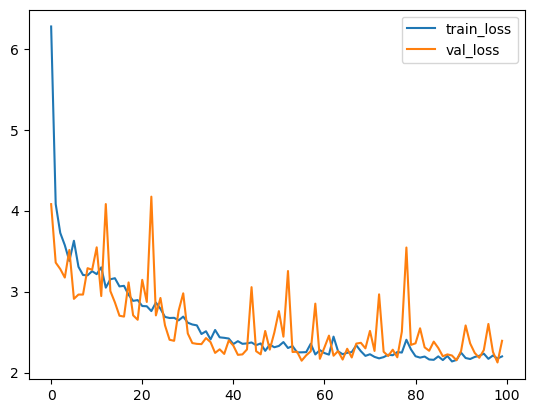

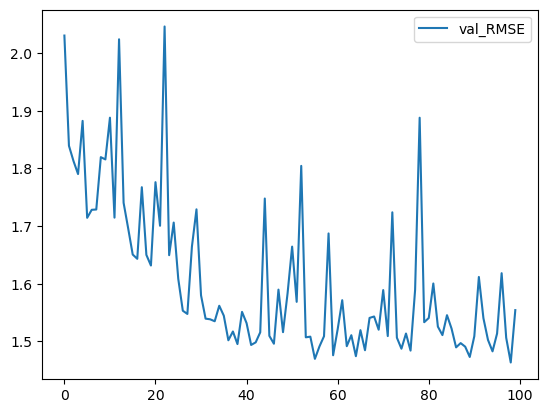

  0%|          | 0/100 [00:00<?, ?it/s]

1.9645092451284683
1.8695090521661268
1.6750308463096497
1.630987461106481
1.6234646622061133
1.5494987214839904
1.5389864733008243
1.5107163231632705
1.4783986332884844
1.4663615324557087
1.4642783484781656
1.4638974072448192
1.4611958315787572
1.4257707761149752


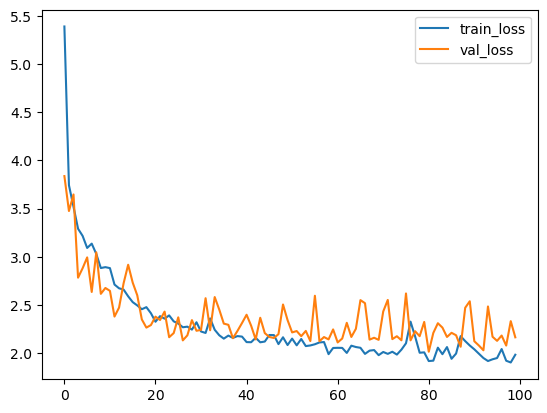

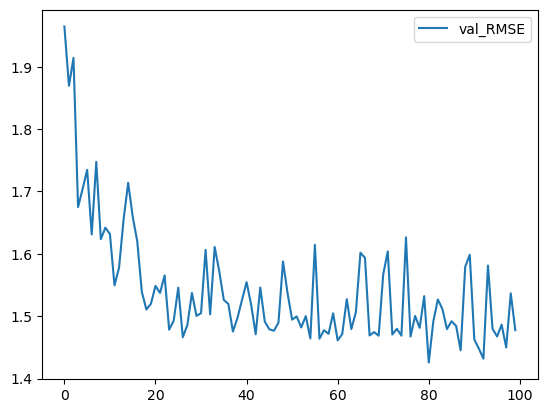

  0%|          | 0/100 [00:00<?, ?it/s]

1.9796013496778186
1.7710201512609822
1.7180211087556132
1.6514778346826984
1.6273566025112718
1.6146672551880779
1.5450881223645512
1.5328282563936904
1.5213490788340844
1.472840842909445
1.4654254664393958
1.4470187040227966
1.4366363978677126
1.4057191331143986
1.4028291348309598


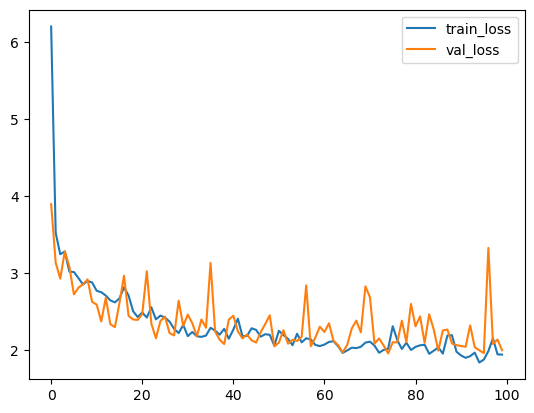

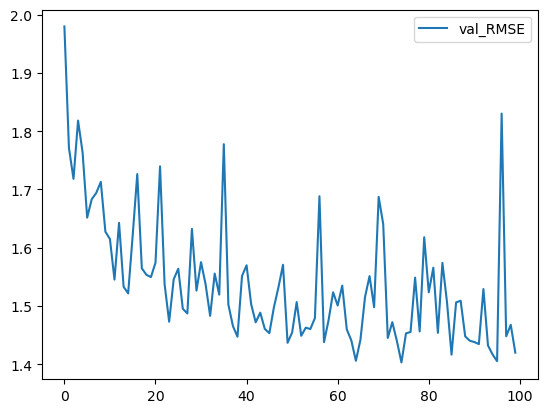

GraphNeuralNetwork(
  (myAttentionModule): MyAttentionModule4(
    (gates): ModuleDict(
      (AtomicNum): GINConv(nn=Sequential(
        (0): Linear(in_features=12, out_features=1, bias=True)
        (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=1, out_features=1, bias=True)
        (4): ReLU()
      ))
      (Degree): GINConv(nn=Sequential(
        (0): Linear(in_features=6, out_features=1, bias=True)
        (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=1, out_features=1, bias=True)
        (4): ReLU()
      ))
      (TotalNumHs): GINConv(nn=Sequential(
        (0): Linear(in_features=5, out_features=1, bias=True)
        (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=1, out_features=1, bias=True)
        (4): ReLU()
 

<Figure size 640x480 with 0 Axes>

In [53]:
######################## wizualizacje #################################################
m = GraphNeuralNetwork(512, my_layer=MyAttentionModule4(3), features_after_layer=3)
visualize(m, train_loader, valid_loader, test_loader, epochs=100, saveImg=True, title="MyAttentionModule4(3)_solubility")

m = GraphNeuralNetwork(512, my_layer=MyAttentionModule4(35), features_after_layer=35)
visualize(m, train_loader, valid_loader, test_loader, epochs=100, saveImg=True, title="MyAttentionModule4(35)_solubility")

m = GraphNeuralNetwork(512, my_layer=MyAttentionModule4(100), features_after_layer=100)
visualize(m, train_loader, valid_loader, test_loader, epochs=100, saveImg=True, title="MyAttentionModule4(100)_solubility")

In [59]:
######################## tabelka ##########################################################
df = pd.DataFrame({"Repr 1": [], "Repr 10": [],
                   "Atention Pooling v2 - size = 3": [], "Atention Pooling v2 - size = 35": [], "Atention Pooling v2 - size = 100": []})
pd.set_option("display.precision", 2)
n_times = 1

for n_convs in [1, 3, 5]:
    for n_channels in [64, 512]:
        row = []

        #########################
        scores = []
        for _ in range(n_times):
            m =  GraphNeuralNetwork(n_channels, n_convs=n_convs, features_after_layer=26)
            m = train_best(m, train_loader1, valid_loader1, epochs=70)
            predictions, att = predict(m, test_loader1)
            rmse_score = rmse(y_test, predictions.flatten())
            scores.append("{:.2f}".format(rmse_score))
        row.append(" | ".join(scores))

        #########################
        scores = []
        for _ in range(n_times):
            m =  GraphNeuralNetwork(n_channels, n_convs=n_convs, features_after_layer=25)
            m = train_best(m, train_loader10, valid_loader10, epochs= 70)
            predictions, att = predict(m, test_loader10)
            rmse_score = rmse(y_test, predictions.flatten())
            scores.append("{:.2f}".format(rmse_score))
        row.append(" | ".join(scores))

        #########################
        for vect_size in [3, 35, 100]:
            scores = []
            for _ in range(n_times):
                m =  GraphNeuralNetwork(n_channels, n_convs=n_convs, my_layer=MyAttentionModule4(vect_size), features_after_layer=vect_size)
                m = train_best(m, train_loader, valid_loader, epochs=70)
                predictions, att = predict(m, test_loader)
                rmse_score = rmse(y_test, predictions.flatten())
                scores.append("{:.2f}".format(rmse_score))
            row.append(" | ".join(scores))

        df.loc[str(n_convs) + " convs, " + str(n_channels) + " channels"] = row

df.to_csv("solubility_out.csv")

  0%|          | 0/70 [00:00<?, ?it/s]

1.9948571132505517
1.879229564969232
1.8643873224412932
1.8619890996484747
1.8532534634982618
1.8520773121947887
1.8460448518191035


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9016782093119144
1.8914242125829643
1.855557993804873
1.8468893599154423
1.8463094251407088


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.0912512592463
1.9683607825886131
1.911669321691486
1.7760558018334733
1.728153040008284
1.7168301288873602
1.7156357521810612
1.691713549936985
1.671567633063081
1.6671042638700866
1.662416523145662
1.6509076799970273
1.6292085288346239
1.624201362118471


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9434486892313954
1.8034359906100996
1.753599566815013
1.7360539472287504
1.6995724435079147
1.684785203211543
1.678569575369675
1.667844857315028
1.645638770313578
1.6382271173492287
1.6372182212532895
1.634202460694471
1.6314607541563373
1.6205517816273773
1.6178952932909996


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9021878349847405
1.8649880751763026
1.778441018247761
1.7568453342854862
1.744333033584964
1.7273615698253866
1.7078250792218033
1.6838994592767405
1.6790637647547648
1.670985254602615
1.655920230860201
1.6488068146389117
1.6320393806313338


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.867732332140029
1.8624850957558186
1.8438254570458488


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9259643262009578
1.9078681524124215
1.8923082737504406
1.8831818627883494
1.866671571198591
1.8659939775068441
1.8570833605116968
1.8538660105969793
1.8488818678119188
1.8396616625958446


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.0905809141116305
1.9880185243873838
1.9008624393672344
1.8986034238174565
1.8599149308153204
1.8399455457882616
1.8098528198587078
1.7713269082846237
1.7646771062920033
1.7638064336682129
1.759713910799492
1.7568100039070054
1.73518484846753
1.7172041214034854
1.7137530021423588
1.7122667765936048
1.6932653448069939
1.6913089201955567
1.691061288143645
1.6907920558886944


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.019803338794589
1.9046141985577998
1.8812179610758204
1.844511877814481
1.795257713799977
1.7681787318843862
1.7395635869344883
1.6991182427492835
1.6853120616731896
1.6849505086206717
1.6840401262783031
1.675085553042185
1.6645962512573584
1.6620834501943507
1.6586733152824225
1.6418202182076669
1.6277060337585767


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.8603717964413329
1.8459723314083978
1.8031547090996023
1.7615277752478633
1.7291396809935446
1.72384616562114
1.6896155090137805
1.6819594454093578
1.6792105109189734
1.6775236299612204
1.656943885123963
1.6569320652602388
1.6556604665762158
1.6533634608163241
1.6268096590662635


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.765845867591523
1.6659182919181068
1.5935023875594496
1.5810706494814708
1.5600012845588573
1.5476560462746518
1.5433723399367336
1.5029280756157906
1.4698389483616419
1.4593542994834996
1.4583233129393969
1.449608641328292
1.4387041623321615
1.4273280355362046
1.4150152257279096
1.3933976681294387


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9141573375915377
1.8023734218745178
1.6570551412558867
1.6500803914040005
1.6300298865217886
1.614810619648596
1.5962205714896753
1.5648331706084726
1.5424992835617082
1.5381584579784353
1.524048814023933
1.5078161730339887
1.5013901061793444
1.4976718649062901
1.4778916834389024
1.465334941633767
1.4650215463698162
1.457181836211857
1.4551799891129893
1.453085321929607


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.00836654555014
1.9529905017064684
1.8167404396028966
1.7748732137431336
1.7370188514956184
1.7178470181438028
1.6981232892066254
1.660481050649888
1.6503634931027
1.6202895857037
1.618601714304443
1.6048801670526087
1.6008289095018242
1.5862747355662068
1.5790337134176136
1.5628764684127678
1.5359301175046345
1.531025568363019
1.5269222536615452
1.5166192167007562
1.5070386853404485


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9098908960989405
1.805621248657202
1.7107921077849624
1.7065188755948724
1.6644768694928218
1.6507678447883942
1.6219538115631547
1.6173357104729855
1.5872732469597326
1.5621886273495633
1.5190093902053676
1.5186109807277384
1.4864466913418373
1.4683937988299496
1.4416980459903073
1.4375961915541584
1.4361603142697577
1.4179199209283604


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9356340536305179
1.8362655289200187
1.7538992359283951
1.7243872190593998
1.709673565868758
1.6586923596597694
1.656600011230524
1.6188966340330444
1.584649413575918
1.5518426680475843
1.5133687032567305
1.504531277090127
1.4877689104326386
1.4781195521220902
1.4498551639538098
1.4201255139927291


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.7347383247319301
1.6694369038339694
1.6453183050526978
1.596285684458332
1.5407087547572536
1.5037421441194256
1.494640615016027
1.4876821810571972
1.46547776515149
1.465451038188646
1.4295597702791447


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.7464794339535896
1.639617678579405
1.6208062237947891
1.5745401459430854
1.5663344911970842
1.5314435214637834
1.5283163966038986
1.515353841029689
1.4995144247691747
1.4957221144133137
1.49473785760415
1.4945847993907406
1.462749827995336
1.4624563258340844
1.454109938549777


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.209964138853499
2.0225632804509024
1.7925422276853917
1.7531060268525394
1.7323639659592651
1.7058293969478837
1.6974097192379938
1.6660074299894343
1.652136306286566
1.6488204256357488
1.631194571036404
1.6293066783284516
1.5889613139682728
1.5811253714453246
1.559672293827448
1.553941948965288
1.5467821061003715
1.5227466901722269


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.04756276213775
2.0263811700667076
1.7909726861361388
1.7611530818901486
1.704516507026975
1.6333093995456194
1.611876188917834
1.6012742307195897
1.5389307878822522
1.5034026142530934
1.4868481901930781
1.4693975376879642
1.4615938650162457
1.4406880873497114
1.4168051990345605


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.7460929476711315
1.6538712081410858
1.6508937700370823
1.6477071076539649
1.600297190706133
1.548914105258228
1.5227163281890979
1.512247398882161
1.4850707041732711
1.4783159441757108
1.463290038361008
1.4386076510691497


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.775455088031947
1.7556894621591708
1.6046841890456076
1.5788499010646526
1.5674172157681006
1.5520686636925338
1.5351213363793155
1.5332229721166848
1.4881803718312652
1.4838578838330543
1.4766234188831011
1.4765441501922945
1.452771102473423
1.450122210014487
1.4248310180112704
1.417339583243616
1.4170767938562765
1.3894317312906646
1.3833811382667822
1.3820494204813762
1.3804817274468268
1.376242032872705
1.3665038855633602
1.3594520152303033


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9133526679210988
1.692158315186503
1.6433845288210236
1.602619827220181
1.5733889773253364
1.5630640277396213
1.5441731537360468
1.5417652923972636
1.5307252824801996
1.5194727547652003
1.5171067924163693
1.499397899950246
1.4768676703176977
1.4738952291022558
1.4688226621837988
1.447482333272062
1.4372058966671857
1.4258609334404624
1.3993434953561188


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.8803645054191074
1.7949576449365054
1.7689315323421881
1.7609876310656438
1.7602002219245056
1.727188396948021
1.7241776326956348
1.7035581810364744
1.6808916684428241
1.671504353537078
1.6459123620591587
1.6307333641055124
1.627258478625255
1.6124827195557654
1.6062041572754784
1.6025766566546886
1.5806324134411662
1.5646736878386354
1.5571088749894029


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9633303874691634
1.7412120632236887
1.6936934535819268
1.6637708075907804
1.656440296911791
1.6271078115071496
1.606262270067941
1.5979188426009312
1.5953139353861845
1.585063567919443
1.5644175685825035
1.5555559532141352
1.5454333778693132
1.5411742763264304
1.5399169144120228
1.5120388992081601


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9398000563662365
1.7900137013656825
1.718365634918595
1.6417823331599548
1.611310208533903
1.588230875441928
1.551873787378378
1.5498533391456397
1.541590736031698
1.5098970894777848
1.476242275653045
1.4741724825854698
1.4664726277509588
1.442701292785761


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.7293620504182945
1.620729834310495
1.6131932405782132
1.5681869594910915
1.5669703172703324
1.545514894551218
1.5284384254149426
1.5191922288057529
1.4976279619756814
1.4945411701946805
1.488543703617974
1.487081339467878
1.4750319225017539
1.4683784101577182
1.4588723473636507
1.4558279681889397
1.4344522013265695
1.4118019573863312


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.9183795627341038
1.7010325656792535
1.6231059526287246
1.6011637442608773
1.5637571138999602
1.5489829907671107
1.545206023584414
1.5330549116879255
1.5187398298269728
1.5115633845983514
1.506486264971141
1.4940765968877214
1.4861448007488216
1.4746872641087432
1.4737322286994443
1.4539593727820048


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.1925293746616403
1.9582992157451178
1.7402899024729284
1.7242026732180205
1.6894421936070676
1.6791262463095158
1.6532771527085515
1.6422168036298201
1.6245873541547637
1.62111677860539
1.604498223981062
1.6029014724816255
1.5857415986421979
1.5829401835230417
1.5815990569454548
1.5747836726425664


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.2886497413726423
2.1588304821374416
1.739685596818494
1.7123269898214393
1.6838320097301644
1.6406071719434832
1.6129728939116035
1.5629569321168681


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.8080399572548365
1.7639907971145028
1.7054717253830143
1.63378052441859
1.6133122898928929
1.6109271426164726
1.587989676872297
1.5567772375822042
1.5545001078575047
1.5440568939573314


  0%|          | 0/32 [00:00<?, ?it/s]

In [60]:
df

,Repr 1,Repr 10,Atention Pooling v2 - size = 3,Atention Pooling v2 - size = 35,Atention Pooling v2 - size = 100
"1 convs, 64 channels",1.89,1.89,1.67,1.68,1.72
"1 convs, 512 channels",1.89,1.89,1.69,1.71,1.67
"3 convs, 64 channels",1.38,1.43,1.52,1.39,1.40
"3 convs, 512 channels",1.41,1.44,1.52,1.39,1.45
"5 convs, 64 channels",1.38,1.43,1.60,1.59,1.44
"5 convs, 512 channels",1.43,1.47,1.67,1.63,1.60


In [64]:
m =  GraphNeuralNetwork(512, n_convs=3, my_layer=MyAttentionModule4(35), features_after_layer=35)
m = train_best(m, train_loader, valid_loader, epochs=70)
predictions, att = predict(m, test_loader)
rmse_score = rmse(y_test, predictions.flatten())
scores.append("{:.2f}".format(rmse_score))

  0%|          | 0/70 [00:00<?, ?it/s]

1.9381299683135942
1.775027736804212
1.7324320715311423
1.713587537046639
1.6650596767812333
1.6482387389809245
1.6294462536636454
1.5485210507901555
1.543295777543309
1.5166924711789065
1.503239948287119
1.501649485187585
1.4968225168984257
1.4762930342387528
1.4754098117096979
1.4742415235641555
1.4580385542059926
1.4567977130907026
1.4432930112874356
1.3878177837809247


  0%|          | 0/32 [00:00<?, ?it/s]

In [65]:
###################### atencja #################################

df_single = pd.DataFrame({"AtomicNum": [], "Degree": [], "TotalNumHs": [], "ImplicitValence": [], "Hybridization": [], "FormalCharge": [],
                          "IsInRing": [], "IsAromatic": [], "NumRadicalElectrons": []})
df_single.style.set_caption("Hello World")

df_batch = pd.DataFrame({"AtomicNum": [], "Degree": [], "TotalNumHs": [], "ImplicitValence": [], "Hybridization": [], "FormalCharge": [],
                          "IsInRing": [], "IsAromatic": [], "NumRadicalElectrons": []})
df_batch.style.set_caption("Hello World")

preds_batches = []
with torch.no_grad():
    for data in test_loader:
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        preds, att = m(x, edge_index, batch)
        preds_batches.append(preds.cpu().detach().numpy())
        att = att.squeeze()
        df_single.loc[len(df_single)] = att[0].tolist()
        df_batch.loc[len(df_single)] = torch.mean(gap(att, batch), dim=0).tolist()
preds = np.concatenate(preds_batches)

rmse_score = rmse(y_test, predictions.flatten())

print(f'RMSE = {rmse_score:.2f}')
df_single.to_csv("solubility_att_single.csv")
df_batch.to_csv("solubility_att_batch.csv")

RMSE = 1.39


In [66]:
df_single[:10]

,AtomicNum,Degree,TotalNumHs,ImplicitValence,Hybridization,FormalCharge,IsInRing,IsAromatic,NumRadicalElectrons
0,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
1,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
2,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
3,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
4,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
5,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
6,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
7,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
8,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
9,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11


In [67]:
df_batch[:10]

,AtomicNum,Degree,TotalNumHs,ImplicitValence,Hybridization,FormalCharge,IsInRing,IsAromatic,NumRadicalElectrons
1,0.1,0.20,0.1,0.1,0.1,0.1,0.1,0.11,0.1
2,0.1,0.21,0.1,0.1,0.1,0.1,0.1,0.11,0.1
3,0.1,0.21,0.1,0.1,0.1,0.1,0.1,0.11,0.1
4,0.1,0.21,0.1,0.1,0.1,0.1,0.1,0.11,0.1
5,0.1,0.21,0.1,0.1,0.1,0.1,0.1,0.11,0.1
6,0.1,0.21,0.1,0.1,0.1,0.1,0.1,0.11,0.1
7,0.1,0.20,0.1,0.1,0.1,0.1,0.1,0.11,0.1
8,0.1,0.21,0.1,0.1,0.1,0.1,0.1,0.11,0.1
9,0.1,0.20,0.1,0.1,0.1,0.1,0.1,0.11,0.1
10,0.1,0.21,0.1,0.1,0.1,0.1,0.1,0.11,0.1
